In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
! pip install ultralytics --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.8/949.8 kB 26.1 MB/s eta 0:00:0000:01


In [2]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="SqxHxUmH1bESmMpTc8Wo")
project = rf.workspace("field-planttutorial").project("field-plant")
version = project.version(2)
dataset = version.download("yolov11")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 88.9 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.10.0 requires tensorflow==2.17.0, but you have tensorflow 2.17.1 which is incompatible.
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Field-plant-2 in yolov11:: 100%|██████████| 9862/9862 [00:12<00:00, 806.48it/s] 


In [3]:
# Import necessary libraries
import torch
import os
import cv2
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from roboflow import Roboflow
from ultralytics import YOLO
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


In [4]:
import os
import pandas as pd
from collections import Counter

labels_path = "/kaggle/working/Field-plant-2/train/labels/"
label_files = os.listdir(labels_path)

class_counts = Counter()

for file in label_files:
    with open(os.path.join(labels_path, file), "r") as f:
        for line in f:
            class_id = line.split()[0]
            class_counts[class_id] += 1

df = pd.DataFrame(class_counts.items(), columns=["Class ID", "Count"])
print(df.sort_values("Count", ascending=True))



   Class ID  Count
25        6      1
17       16      6
23       12      7
20       13      8
22       25     11
18       17     13
19       10     13
14        0     17
24        7     21
13        8     27
15       20     30
21       11     33
11        4     50
3        26     75
12       15    113
6         9    115
8         1    128
16        5    156
10       14    180
9        24    190
4        23    273
7         2    286
0        18    338
2        21   1142
5        19   1164
1         3   1367


In [7]:
if class_id in ['6', '16', '12', '13', '25', '10','17','0','7','8','20','11']:  # Undersampled classes
    transform = A.Compose([
        # A.Resize(640, 640),
        # A.RandomBrightnessContrast(p=0.5),  # Higher probability
        # A.HorizontalFlip(p=0.7),
        # A.VerticalFlip(p=0.7),
        # A.Rotate(limit=30, p=0.7),  # More aggressive rotation
        # A.Blur(blur_limit=3, p=0.3),
        # A.Cutout(num_holes=8, max_h_size=8, max_w_size=8, p=0.5)  # Add cutout for more diversity
        A.Resize(640, 640),
        A.RandomBrightnessContrast(p=0.3),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=30, p=0.5),
        A.MotionBlur(blur_limit=5, p=0.2),  # Add Motion Blur
        A.CLAHE(p=0.2),  # Contrast Limited Adaptive Histogram Equalization
        A.ISONoise(p=0.3),  # Simulate camera noise
        A.RandomGamma(p=0.3)  # Adjust image gamma
    ])
else:
    transform = A.Compose([
        A.Resize(640, 640),
        A.RandomBrightnessContrast(p=0.2),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=20, p=0.5),
        A.Blur(blur_limit=3, p=0.2)
    ])


In [6]:
# Define image preprocessing and augmentation
transform = A.Compose([
    A.Resize(640, 640),
    A.RandomBrightnessContrast(p=0.3),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.MotionBlur(blur_limit=5, p=0.2),  # Add Motion Blur
    A.CLAHE(p=0.2),  # Contrast Limited Adaptive Histogram Equalization
    A.ISONoise(p=0.3),  # Simulate camera noise
    A.RandomGamma(p=0.3)  # Adjust image gamma
])


In [8]:
# Path to training images and labels
train_images_path = "/kaggle/working/Field-plant-2/train/images/"
train_labels_path = "/kaggle/working/Field-plant-2/train/labels/"

# Load and preprocess a sample image
sample_image_path = os.path.join(train_images_path, os.listdir(train_images_path)[0])
image = cv2.imread(sample_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
augmented = transform(image=image)["image"]

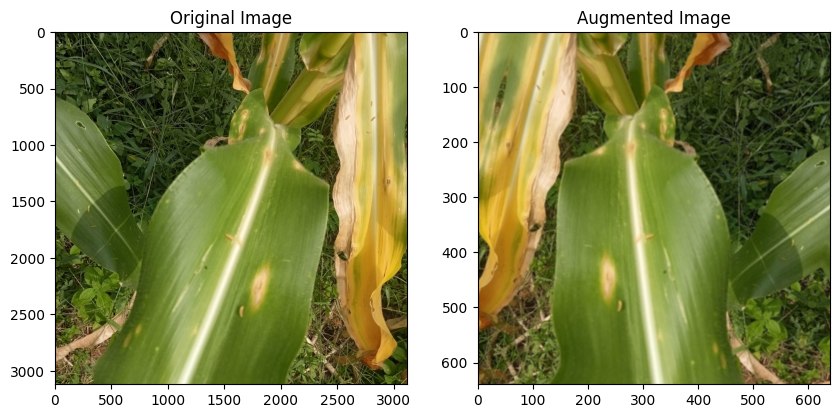

In [9]:
# Display the original and augmented image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].set_title("Original Image")
ax[1].imshow(augmented)
ax[1].set_title("Augmented Image")
plt.show()

In [10]:
import cv2
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Feature Mapping using PCA
def feature_mapping(image_path, pca_components=10):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
    img = cv2.resize(img, (64, 64))  # Resize to 64x64
    img_flat = img.reshape(64, 64)  # Keep 2D structure

    scaler = StandardScaler()
    img_scaled = scaler.fit_transform(img_flat)  # Normalize pixel values

    pca = PCA(n_components=min(pca_components, img_scaled.shape[1]))  # Ensure valid component count
    img_pca = pca.fit_transform(img_scaled)  # Apply PCA

    return img_pca

# Test with sample image
feature_map = feature_mapping(sample_image_path, pca_components=10)
print("Feature Mapping Output Shape:", feature_map.shape)


Feature Mapping Output Shape: (64, 10)


In [11]:
!yolo detect train data=/kaggle/working/Field-plant-2/data.yaml \
    model=yolo11l.pt epochs=40 batch=16 lr0=0.0001 imgsz=640 iou=0.75 \
    hsv_h=0.02 hsv_s=0.8 hsv_v=0.5 mosaic=1.0 mixup=0.5 dropout=0.5 \
    cos_lr=True patience=5 weight_decay=0.0005 momentum=0.95 warmup_epochs=5 \
    auto_augment=randaugment erasing=0.5 copy_paste=0.2 augment=False \
    project=/kaggle/working/training_results name=run_finetuned_v2


# !ls /content/drive/MyDrive/
# !cp -r /content/training_results /content/drive/MyDrive/Yolo_Training_Results

100%|███████████████████████████████████████| 49.0M/49.0M [00:00<00:00, 275MB/s]
Ultralytics 8.3.94 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11l.pt, data=/kaggle/working/Field-plant-2/data.yaml, epochs=40, time=None, patience=5, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/kaggle/working/training_results, name=run_finetuned_v2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.5, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.75, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=

In [18]:
ls /kaggle/working/training_results/run_finetuned_v2


args.yaml                                         train_batch1.jpg
confusion_matrix_normalized.png                   train_batch2.jpg
confusion_matrix.png                              train_batch6480.jpg
events.out.tfevents.1742568693.ecd3754dd295.89.0  train_batch6481.jpg
F1_curve.png                                      train_batch6482.jpg
labels_correlogram.jpg                            val_batch0_labels.jpg
labels.jpg                                        val_batch0_pred.jpg
P_curve.png                                       val_batch1_labels.jpg
PR_curve.png                                      val_batch1_pred.jpg
R_curve.png                                       val_batch2_labels.jpg
results.csv                                       val_batch2_pred.jpg
results.png                                       weights/
train_batch0.jpg


In [1]:
import pandas as pd

# Load the CSV file
csv_path = "/kaggle/working/training_results/results.csv"
df = pd.read_csv(csv_path)

# Display the first few rows
df.head()


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/training_results/results.csv'